## Covid-19 Segmentation

Upvote base notebook: https://www.kaggle.com/code/oskaradolfovillalpez/covid-segmentation/notebook

### Ethics

The data is anonymous to mantain confidentiality of the persons scanned. 


## Introduction

### Problem Description

In the diagnosis of patients with COVID-19, one of the most common tools is computed tomography. CT images allow radiologists to observe the state of the lungs in detail and detect signs of damage, such as areas affected by viral infections. However, manually analyzing each CT image to segment the affected areas is an intensive and time-consuming task. These affected areas are key indicators of the severity of the disease and the extent of lung damage.

Given that the COVID-19 pandemic has significantly increased the workload of radiologists, the need for automated solutions to accelerate and improve the diagnostic process has gained great importance. The main problem addressed in this challenge is the automation of the process of segmenting these lesions in the lungs of COVID-19 patients, with the aim of improving accuracy and reducing the time needed to obtain a diagnosis.

### Objective of the Kaggle Competition

The Kaggle competition aims to develop automatic segmentation models that can identify and delineate areas of "ground glass opacity" and "consolidation" in CT images of patients' lungs.

### Ground glass opacity

The term "ground glass" refers to an opacity in the lungs that appears in CT images. These areas indicate a higher density within the lungs, meaning that something is partially filling the air spaces within the lungs. This can represent lung inflammation caused by infection.

### Consolidation

Consolidation refers to a condition in which the air-filled spaces in the lung alveoli are replaced by fluid, pus, blood, or other substances.

### Differences

* Density: Ground glass is less dense than consolidation.
* Severity: Ground glass usually appears in initial or less severe phases compared to consolidation, which tends to occur in more advanced stages.

### Importance of segmentation in medical images

* Precision and Speed: Automatic segmentation of CT images will allow radiologists to obtain a faster and more accurate assessment of lung damage.
* Standardized Diagnosis: AI-based automated systems can help standardize the diagnostic process, eliminating variability between different radiologists and improving the consistency of results.
* Data Analysis:
* We import the following libraries:
    * numpy: Efficient handling of arrays and advanced mathematical operations
    * pandas: Facilitates working with data structures
    * matplotlib: Serves to generate graphs
    * os: Provides functions to interact with the operating system, such as accessing files and directories.

In [1]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.3 MB/s eta 0:00:0000:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=c1b94a5a422ea73f4a731b5b7574730de1032bff13576d5f1c23f431f532073b
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=d0f64c6863f596b1b573d2a98781e106edfe0dc3ad13bdad9351ee8dcfba1369
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-py

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-segmentation/masks_medseg.npy
/kaggle/input/covid-segmentation/images_medseg.npy
/kaggle/input/covid-segmentation/test_images_medseg.npy
/kaggle/input/covid-segmentation/masks_radiopedia.npy
/kaggle/input/covid-segmentation/images_radiopedia.npy


## Loading the data files

The following code loads various datasets from a base path. It loads images and masks from 'radiopedia' and 'medseg' datasets, as well as test images. The data is loaded as NumPy arrays and converted to specific data types (float32 for images, int8 for masks).

In [3]:
base_path = '/kaggle/input/covid-segmentation'

In [4]:
images_radiopedia = np.load(os.path.join(base_path, 'images_radiopedia.npy')).astype(np.float32)
masks_radiopedia = np.load(os.path.join(base_path, 'masks_radiopedia.npy')).astype(np.int8)

In [5]:
images_medseg = np.load(os.path.join(base_path, 'images_medseg.npy')).astype(np.float32)
masks_medseg = np.load(os.path.join(base_path, 'masks_medseg.npy')).astype(np.int8)

In [6]:
test_images_medseg = np.load(os.path.join(base_path, 'test_images_medseg.npy')).astype(np.float32)

## Visualizing random samples

A function named `visualize` is defined to display batches of images and their corresponding masks. It uses matplotlib to create subplots for each sample. The function can display the original images, masks, and optionally predicted masks.

In [7]:
import matplotlib.pyplot as plt

In [8]:
def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8, hot_encode=True):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(
        num_classes + 1,
        num_samples,
        figsize=(num_samples * 2, (num_classes + 1) * 2)
    )
    
    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        
        if hot_encode:
            ax_image.imshow(image_batch[i, :, :, 0], cmap="Greys")

        else:
            ax_image.imshow(image_batch[i, :, :], cmap="bone")
            
        ax_image.set_xticks([])
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i, :, :, j]
                    
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                    
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([])
                ax[j + 1, i].set_yticks([])
                
    plt.tight_layout()
    plt.show()

The code visualizes a subset of the 'radiopedia' dataset (indices 30 - 37). It shows the original CT scans, along with two types of mask visualizations.

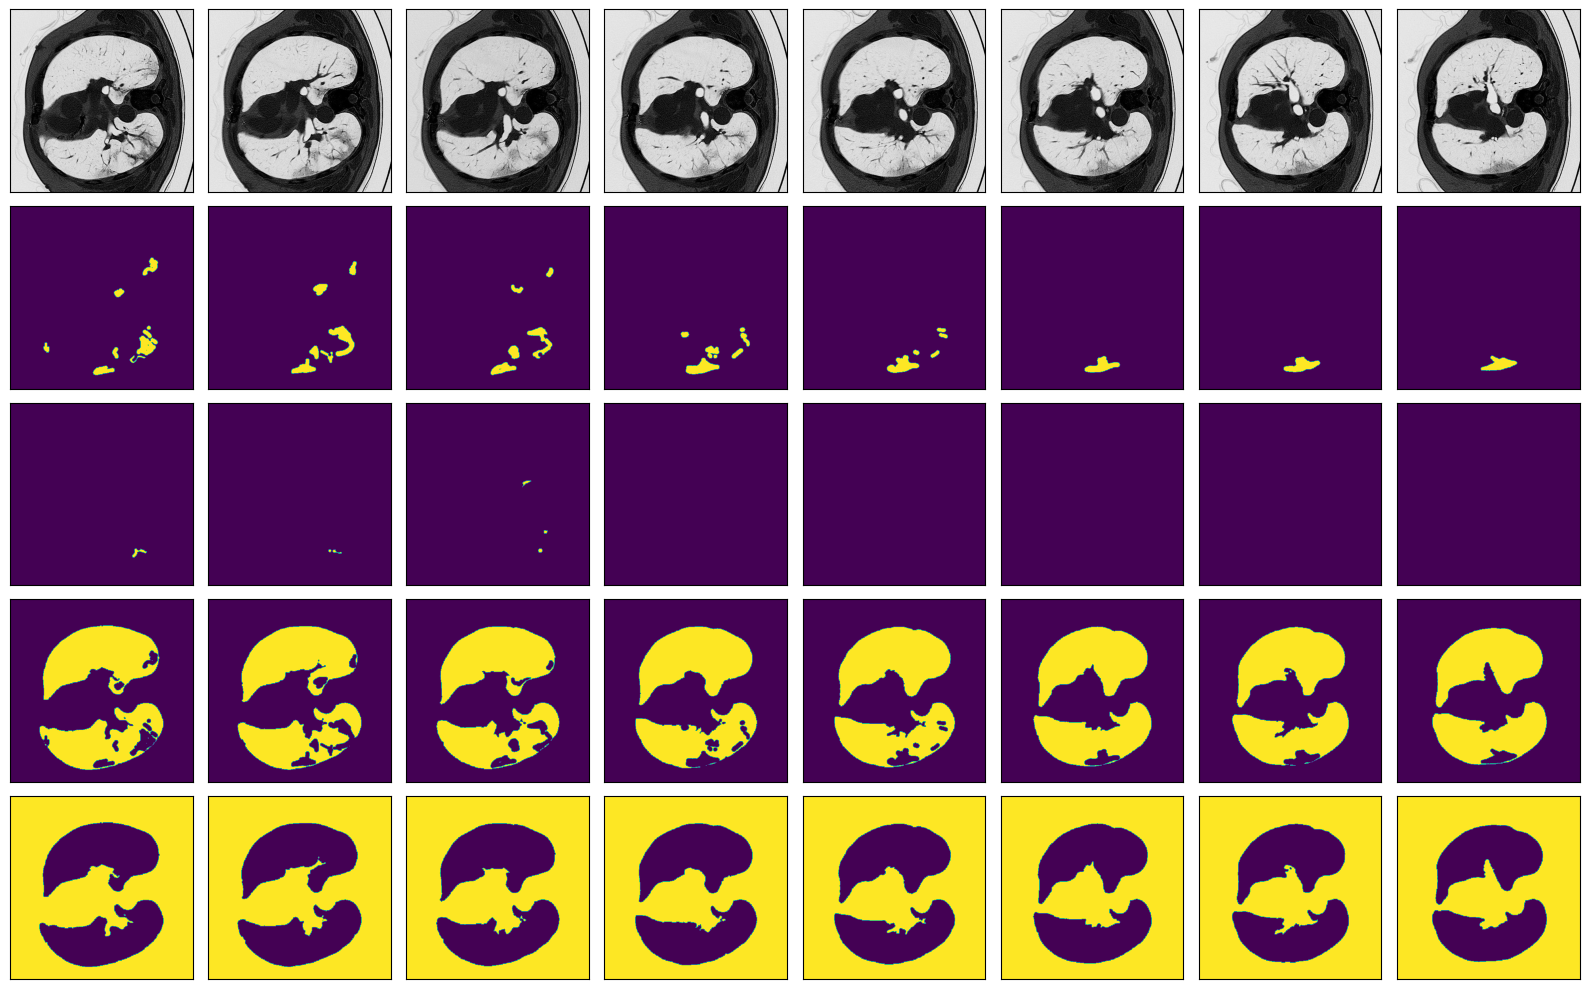

In [9]:
visualize(images_radiopedia[30:], masks_radiopedia[30:])

## Converting the masks

Convert one-hot encoded masks to a palette-based representation. This function is used to process both 'radiopedia' and 'medseg' masks.

In [ ]:
from typing import List, Tuple

In [10]:
def onehot_to_mask(mask: np.ndarray, palette: List[Tuple[int, int, int]]) -> np.ndarray:    
    x = np.argmax(mask, axis=-1)
    color_codes = np.array(palette)
    
    return np.uint8(color_codes[x.astype(np.uint8)])

In [11]:
palette = [[0], [1], [2], [3]]
masks_radiopedia_recover = onehot_to_mask(masks_radiopedia, palette).squeeze()
masks_medseg_recover = onehot_to_mask(masks_medseg, palette).squeeze()

print(f"Hot encoded mask size: {masks_radiopedia.shape}")
print(f"Palette mask size: {masks_medseg_recover.shape}")

Hot encoded mask size: (829, 512, 512, 4)
Palette mask size: (100, 512, 512)


The processed 'medseg' masks are visualized using the `visualize` function.

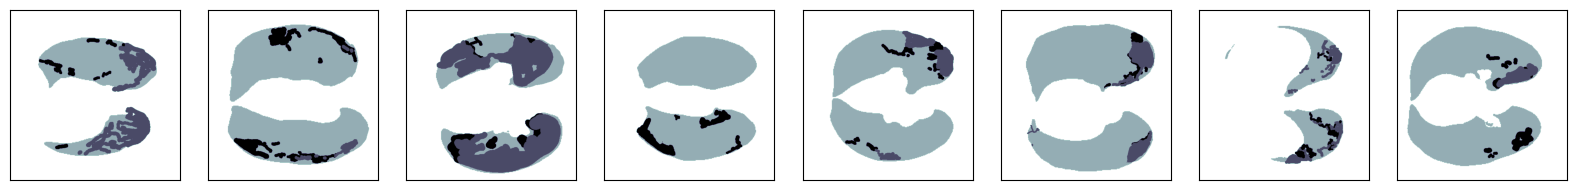

In [12]:
visualize(masks_medseg_recover[30:], hot_encode=False)

## Preprocess images

In [13]:
from typing import Optional

The `preprocess_images` is defined to process the image arrays:

- Input: numpy array of images, optional mean and std for normalization.
- Parameters: clip_min/clip_max for value clamping, lower/upper percentiles for filtering.
- Process: clips values, filters based on percentiles, normalizes using mean and std.
- Output: preprocessed image arrays and (mean, std) tuple.

In [14]:
def preprocess_images(
    images_arr: np.ndarray,
    mean_std: Optional[Tuple[float, float]] = None,
    clip_min: float = -1500,
    clip_max: float = 500,
    lower_percentile: float = 5,
    upper_percentile: float = 95
) -> Tuple[np.ndarray, Tuple[float, float]]:
    """
    Preprocess image array by clipping, filtering, and normalizing.

    Args:
        images_arr (np.ndarray): Input image array.
        mean_std (Optional[Tuple[float, float]]): Pre-computed mean and std for normalization.
        clip_min (float): Minimum value for clipping.
        clip_max (float): Maximum value for clipping.
        lower_percentile (float): Lower percentile for filtering.
        upper_percentile (float): Upper percentile for filtering.

    Returns:
        Tuple[np.ndarray, Tuple[float, float]]: Preprocessed image array and (mean, std) tuple.
    """
    
    images_arr = np.clip(images_arr, clip_min, clip_max)
    min_perc, max_perc = np.percentile(images_arr, [lower_percentile, upper_percentile])
    valid_images = images_arr[(images_arr > min_perc) & (images_arr < max_perc)]
    
    if mean_std is None:
        mean, std = float(valid_images.mean()), float(valid_images.std())   
    else:
        mean, std = mean_std
        
    images_arr = (images_arr - mean) / std
    print(f"Mean: {mean}, std: {std}")
    
    return images_arr, (mean, std)

Three datasets are processed using `preprocess_image`: images_radiopedia, images_medseg, and test_images_medseg.

In [15]:
images_radiopedia, mean_std = preprocess_images(images_radiopedia)

Mean: -451.6488342285156, std: 458.5679016113281


In [16]:
images_medseg, _ = preprocess_images(images_medseg, mean_std)

Mean: -451.6488342285156, std: 458.5679016113281


In [17]:
test_images_medseg, _ = preprocess_images(test_images_medseg, mean_std)

Mean: -451.6488342285156, std: 458.5679016113281


## Histogram plotting

Plots histograms for one or two image sets. Uses different colors (blue/orange) and transparency for comparison.

In [18]:
def plot_hists(images1, images2=None):
    plt.hist(images1.ravel(), 
             bins=100,
             density=True,
             color='b',
             alpha=1 if images2 is not None else 0.5
    )
    
    if images2 is not None:
        plt.hist(images2.ravel(), bins=100, density=True, alpha=0.5, color='orange')
        
    plt.show();

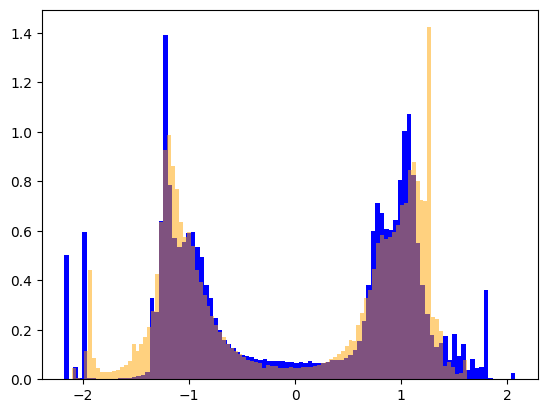

In [19]:
plot_hists(test_images_medseg, images_radiopedia)

## Dataset splits

Masks for radiopedia and medseg datasets are processed using `onehot_to_mask`. Dataset is split into validation (indices 0 - 23) and training (indices 24 - 99). Training data combines medseg and radiopedia images/masks. Validation data uses only medseg images/masks.

In [20]:
masks_radiopedia_recover = onehot_to_mask(masks_radiopedia, palette).squeeze()
masks_medseg_recover = onehot_to_mask(masks_medseg, palette).squeeze()

In [21]:
val_indices, train_indices = list(range(24)), list(range(24, 100))

In [22]:
train_images = np.concatenate((images_medseg[train_indices], images_radiopedia))
train_masks = np.concatenate((masks_medseg_recover[train_indices], masks_radiopedia_recover))

In [23]:
val_images = images_medseg[val_indices]
val_masks = masks_medseg[val_indices]

In [24]:
batch_size = len(val_masks)
print(f"Batch size: {batch_size}")

Batch size: 24


In [25]:
del masks_medseg_recover
del masks_radiopedia_recover
del images_radiopedia
del masks_radiopedia
del images_medseg
del masks_medseg

## Data generator and augmentations

- Albumentations library imported for image augmentation.
- OpenCV (cv2) imported for image processing.
- Constants defined: SOURCE_SIZE and TARGET_SIZE.
- Augmentation pipeline for train images created with
    - Random rotation (±360°)
    - Random sized crop (75% to 100% of original size)
    - Resizing to TARGET_SIZE
    - Horizontal flip (50% chance)
- Augmentation pipeline for validation images created with
    - Resizing to TARGET_SIZE

In [26]:
import albumentations as A
import cv2

In [27]:
SOURCE_SIZE: int = 512
TARGET_SIZE: int = 256

In [28]:
train_transformations = A.Compose([
    A.Rotate(limit=360, p=0.9, border_mode=cv2.BORDER_REPLICATE),
    A.RandomSizedCrop((int(SOURCE_SIZE * 0.75), SOURCE_SIZE), 
                      TARGET_SIZE,
                      TARGET_SIZE,
                      interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(p=0.5)
])

In [29]:
val_transformations = A.Compose([
    A.Resize(TARGET_SIZE, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
])

## Dataset

In [30]:
import torch
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader  
from PIL import Image

Checks for CUDA availability and sets up the device. 

In [31]:
is_cuda_available = torch.cuda.is_available()

if is_cuda_available:
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
    
device = torch.device("cuda:0")
torch.cuda.set_device(device)
print(f'Selected device is: {device}')

CUDA device count: 1
Current CUDA device: 0
CUDA device name: Tesla P100-PCIE-16GB
Selected device is: cuda:0


Defines a dataset class for handling images and mask data. It:

- Initializes with images, masks, and optional augmentations.
- Sets mean and std for normalization.
- Implements `getitem` method for data loading and preprocessing.
- Applies augmentations if needed.
- Normalizes images and converts masks to tensors.
- Implements `tiles` method for image and mask tiling.
- Implements `len` method.

In [32]:
class Dataset:
    def __init__(
        self,
        images,
        masks,
        augmentations=None
    ):
        self.images = images
        self.masks = masks
        self.augmentations = augmentations
        
        self.mean = [0.485]
        self.std = [0.229]
        
    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        
        if self.augmentations is not None:
            sample = self.augmentations(image=image, mask=mask)
            image, mask = Image.fromarray(np.squeeze(sample['image'], axis=2)), sample['mask']
            
        if self.augmentations is None:
            image = Image.fromarray(image)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        image = t(image)
        mask = torch.from_numpy(mask).long()
            
        return image, mask
    
    def tiles(self, image, mask):
        img_patches = image.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches
    
    def __len__(self):
        return len(self.images)

Creates train_dataset and val_dataset instances. Sets up train_loader and val_loader with specified batch sizes

In [33]:
train_dataset = Dataset(train_images, train_masks, train_transformations)
val_dataset = Dataset(val_images, val_masks, val_transformations)

In [34]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Implements mask_to_onehot function to convert masks to one-hot encoded format.

In [35]:
def mask_to_onehot(mask, palette):
    semantic_map = []
    
    for color in palette:
        equality = np.equal(mask, color)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
        
    semantic_map = np.stack(semantic_map, axis=-1).astype(np.float32)
    
    return torch.from_numpy(semantic_map)

In [36]:
i, train_data = next(enumerate(train_loader))

Visualizes sample images and their corresponding masks

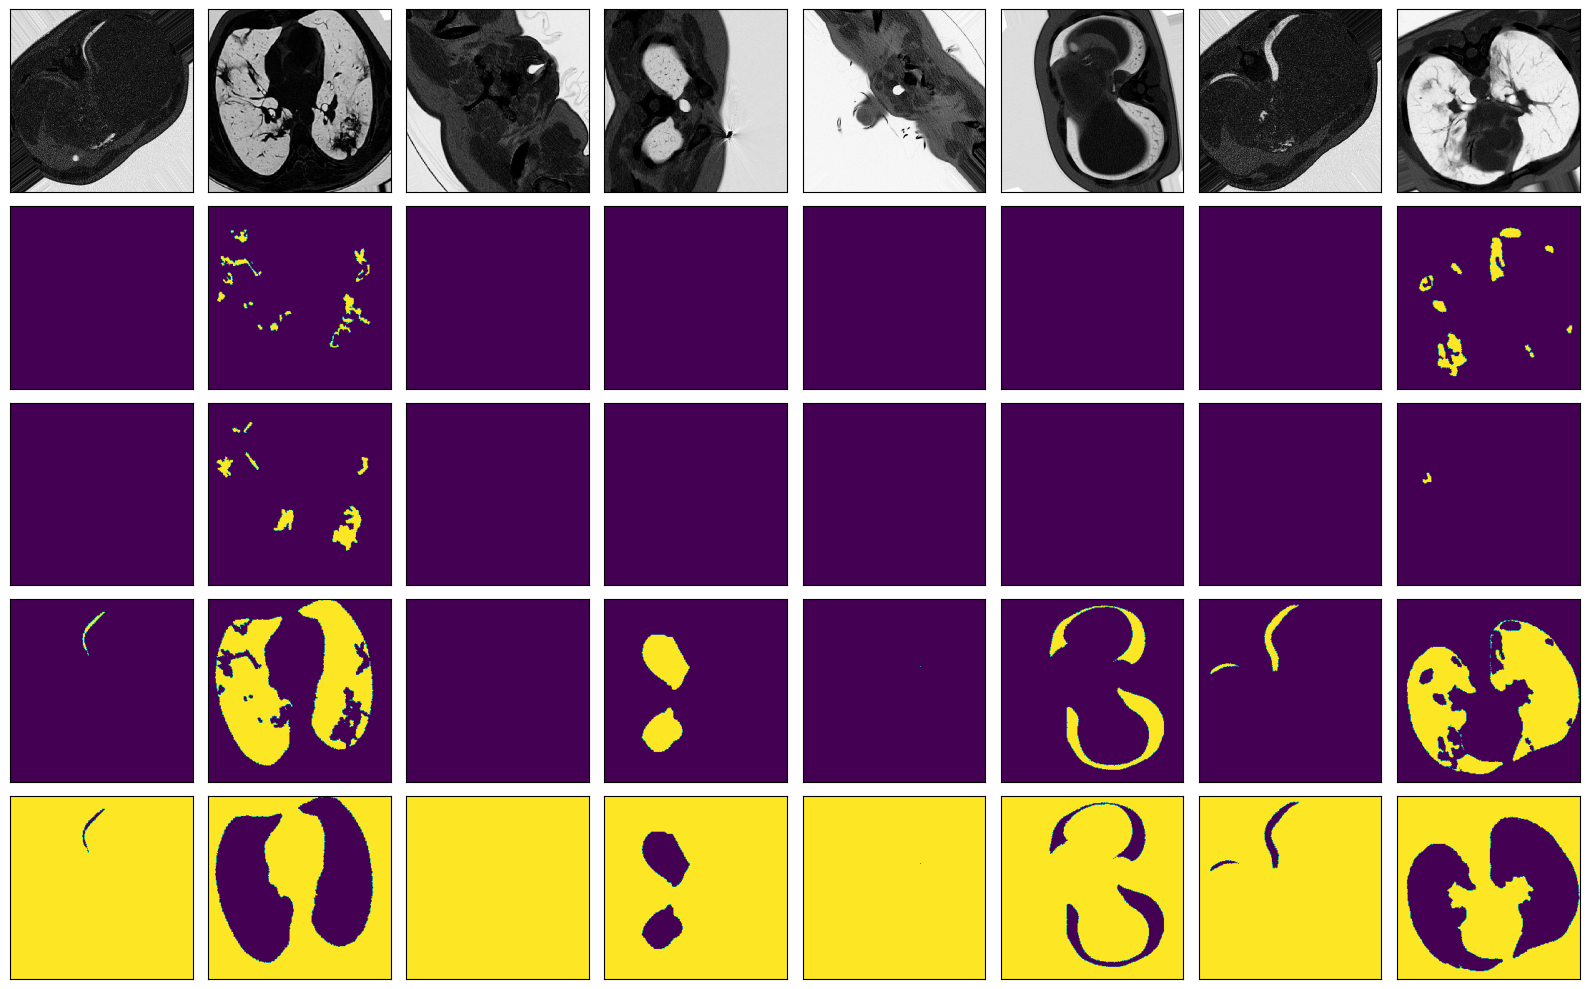

In [37]:
encoded_mask = mask_to_onehot(torch.unsqueeze(train_data[1], -1).numpy(), palette)
visualize(train_data[0].permute(0, 2, 3,1), encoded_mask)

## Evaluation Metrics

- Implements `pixel_accuracy` function to calculate pixel-wise accuracy.
- Implements `mIoU` function to calculate mean Intersection over Union.
- Implements `iou` function for binary IoU calculation.

In [38]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
        
    return accuracy

In [78]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=4):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        mask = torch.argmax(mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)
        
        iou_per_category = []
        
        for category in range(0, n_classes):
            true_category = pred_mask == category
            true_label = mask == category
            
            if true_label.long().sum().item() == 0:
                iou_per_category.append(np.nan)
                
            else:
                interest = torch.logical_and(true_category, true_label).sum().float().item()
                union = torch.logical_or(true_category, true_label).sum().float().item()
                
                iou = (interest + smooth) / (union + smooth)
                iou_per_category.append(iou)
                
        return np.nanmean(iou_per_category)

In [40]:
def iou(pred, gt):
    pred = pred.squeeze().cpu().data.numpy()
    pred = ToLabel(pred)
    
    gt = gt.squeeze().cpu().data.numpy()
    agg = pred + gt
    
    i, u = float(np.sum(agg == 2)), float(np.sum(agg > 0))
    if u == 0:
        result = 1
        
    else:
        result = i / u
        
    return result

## Model Definition

- Imports segmentation models from a custom module.
- Defines `create_model` function to instantiate either `DeepLabV3Plus` or `Unet` models.
- Set up model parameters like encoder name, weights, input channels, and number of classes.

In [41]:
import segmentation_models_pytorch as smp

In [42]:
def create_model(architecture, 
                 encoder_name='efficientnet-b5',
                 encoder_weights='imagenet',
                 in_channels=1,
                 classes=4
):
    if architecture == 'DeepLabV3Plus':
        return smp.DeepLabV3Plus(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=in_channels,
            classes=classes,
            activation=None
        )
    
    elif architecture == 'Unet':
        return smp.Unet(
            encoder_name=encoder_name,
            in_channels=in_channels,
            encoder_weights=encoder_weights,
            classes=classes,
            activation=None,
        )
    
    else:
        raise ValueError(f"Unknown architecture: {architecture}")

Implements get_learning_rate function to extract learning rate from optimizer

In [43]:
def get_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

## Model Training Functions

- Batch evaluation function handles image and mask tiling. 
    - Processes masks based on their dimensions.
    - Computes model output, loss, IoU, and pixel accuracy.
    - Returns loss, IoU, and accuracy for the batch.
    
- Training epoch function
    - Iterates through the training data using tqdm for progress tracking.
    - Calls `evaluate_batch` for each batch.
    - Performs backpropagation and optimization steps.
    - Updates learning rate using the scheduler.
    - Returns average loss, IoU, accuracy, and learning rates for the epoch.
    
- Validation epoch function
    - Similar to `train_epoch`, but without optimization steps.
    - Uses `torch.no_grad()` for efficiency during validation.
    - Returns average loss, IoU, and accuracy for the validation set.
    
- Model fitting function
    - Initializes history dictionary to track metrics.
    - Implements early stopping with a patience parameter.
    - Trains for the specified number of epochs.
    - Calls `train_epoch` and `validate_epoch` for each epoch.
    - Tracks and updates best model based on validation loss.
    - Returns training history.

In [44]:
import torch.nn as nn
import torch.nn.functional as F
import time
from typing import List, Dict
from tqdm import tqdm

In [45]:
def evaluate_batch(model: nn.Module,
                   data: Tuple[torch.Tensor, torch.Tensor],
                   criterion: nn.Module,
                   device: torch.device
) -> Tuple[torch.Tensor, float, float]:
    image_tiles, mask_tiles = data
    image = image_tiles.to(device)
    mask = mask_tiles.to(device)
    
    if mask.dim() == 4:
        if mask.size(3) == 1:
            mask = mask.squeeze(3)
        else:
            mask = mask.argmax(dim=3)
    
    output = model(image)
    loss = criterion(output, mask)
    iou = mIoU(output, mask)
    accuracy = pixel_accuracy(output, mask)
    
    return loss, iou, accuracy

In [46]:
def train_epoch(model: nn.Module,
                train_loader: DataLoader,
                criterion: nn.Module,
                optimizer: torch.optim.Optimizer,
                scheduler: torch.optim.lr_scheduler._LRScheduler,
                device: torch.device
) -> Tuple[float, float, float, List[float]]:
    model.train()
    
    running_loss = 0
    iou_score = 0
    accuracy = 0
    lrs = []
    
    for data in tqdm(train_loader, desc="Training"):
        loss, iou, acc = evaluate_batch(model, data, criterion, device)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        lrs.append(get_learning_rate(optimizer))
        scheduler.step()
        
        running_loss += loss
        iou_score += iou
        accuracy += acc
        
    return (
        running_loss / len(train_loader),
        iou_score / len(train_loader),
        accuracy / len(train_loader),
        lrs
    )

In [47]:
def validate_epoch(model: nn.Module,
                   val_loader: DataLoader,
                   criterion: nn.Module,
                   device: torch.device
) -> Tuple[float, float, float]:
    model.eval()
    
    running_loss = 0
    iou_score = 0
    accuracy = 0
    
    with torch.no_grad():
        for data in tqdm(val_loader, desc="Validating"):
            loss, iou, acc = evaluate_batch(model, data, criterion, device)
            
            running_loss += loss
            iou_score += iou
            accuracy += acc
            
    return (
        running_loss / len(val_loader),
        iou_score / len(val_loader),
        accuracy / len(val_loader)
    )

In [48]:
def fit(
    epochs: int,
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer, 
    scheduler: torch.optim.lr_scheduler._LRScheduler,
    device: torch.device,
    patience: int = 7
) -> Dict[str, List[float]]:
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_miou': [],
        'val_miou': [],
        'train_acc': [],
        'val_acc': [],
        'lrs': []
    }
    
    min_loss = float('inf')
    not_improve = 0
    
    model.to(device)
    fit_time = time.time()
    
    for epoch in range(epochs):
        since = time.time()
        
        train_loss, train_iou, train_acc, lrs = train_epoch(model,
                                                            train_loader,
                                                            criterion,
                                                            optimizer,
                                                            scheduler,
                                                            device)
        
        val_loss, val_iou, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_miou'].append(train_iou)
        history['val_miou'].append(val_iou)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['lrs'].extend(lrs)
        
        if val_loss < min_loss:
            print(f"Loss decreasing {min_loss:.3f} >> {val_loss:.3f}")
            
            min_loss, not_improve = val_loss, 0
            if (epoch + 1) % 5 == 0:
                print('Saving best model')
                torch.save(model, f"Unet_efficientnet_b2_mIoU-{val_iou:.3f}.pt")
                
            else:
                not_improve += 1
                print(f"Loss did not decrease for {not_improve} time")
                
                if not_improve == patience:
                    print(f'Loss not decrease for {patience} times, Stop Training')
                    break
            
        print(f"Epoch:{epoch+1}/{epochs}.. "
              f"Train Loss: {train_loss:.3f}.. "
              f"Val Loss: {val_loss:.3f}.. "
              f"Train mIoU:{train_iou:.3f}.. "
              f"Val mIoU: {val_iou:.3f}.. "
              f"Train Acc:{train_acc:.3f}.. "
              f"Val Acc:{val_acc:.3f}.. "
              f"Time: {(time.time()-since)/60:.2f}m")

    print(f'Total time: {(time.time() - fit_time)/60:.2f} m')
    return history   

## Hyperparameters

* Learning rate: 1e-3
* Number of epochs: 25Creates the model using create_model function
* Weight decay: 1e-4
* Loss function: nn.CrossEntropyLoss()

In [49]:
learning_rate: float = 1e-3
epochs: int = 25
weight_decay: float = 1e-4
criterion = nn.CrossEntropyLoss()

### Train Model Function

Creates the model using `create_model` function. Sets up optimizer (Adam) and learning rate scheduler (OneCycleLR). Calls the `fit` function to train the model.

In [51]:
def train_model(model_name, 
                encoder_name,
                epochs,
                learning_rate,
                train_loader,
                val_loader,
                criterion, 
                device
):
    model = create_model(model_name, encoder_name)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                    max_lr=learning_rate,
                                                    total_steps=epochs * len(train_loader))

    history = fit(
        epochs,
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        scheduler,
        device
    )
    
    return history, model

## Model Visualizations

* `plot_loss(history)`: Plots training and validation loss per epoch
* `plot_score(history)`: Plots training and validation mean IoU per epoch
* `plot_acc(history)`: Plots training and validation accuracy per epoch

In [52]:
def plot_loss(history):
    val_loss = [loss.cpu().detach().numpy() for loss in history['val_loss']]
    train_loss = [loss.cpu().detach().numpy() for loss in history['train_loss']]

    plt.plot(val_loss, label='validation', marker='o')
    plt.plot(train_loss, label='training', marker='o')
    
    plt.title('Loss per epoch')
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    
    plt.legend()
    plt.grid()
    plt.show()

In [53]:
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    
    plt.title('Score per epoch')
    plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    
    plt.legend()
    plt.grid()
    plt.show()

In [54]:
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    
    plt.title('Accuracy per epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    
    plt.legend()
    plt.grid()
    plt.show()

## Model Training

Two models were trained: Unet with EfficientNet-B2 encoder and DeepLabV3Plus with EfficientNet-B3 encoder.

### Unet EfficientNet-B2 Model Results

* Loss decreased significantly in the first few epochs and then stabilized.
* mIoU (Score) improved rapidly initially, then showed gradual improvement.
* Accuracy reached high levels quickly and continued to improve slightly.
* Final metrics (approx.):
    - Validation Loss: 0.2
    - Validation mIoU: 0.68
    - Validation Accuracy: 0.97

In [57]:
history_unet, unet_model = train_model(
    'Unet', 
    'efficientnet-b2', 
    epochs, 
    learning_rate, 
    train_loader, 
    val_loader, 
    criterion, 
    device
)

Validating: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


Loss decreasing inf >> 2.143
Loss did not decrease for 1 time
Epoch:1/25.. Train Loss: 1.917.. Val Loss: 2.143.. Train mIoU:0.070.. Val mIoU: 0.078.. Train Acc:0.146.. Val Acc:0.145.. Time: 0.18m


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


Loss decreasing 2.143 >> 1.175
Loss did not decrease for 1 time
Epoch:2/25.. Train Loss: 1.247.. Val Loss: 1.175.. Train mIoU:0.228.. Val mIoU: 0.268.. Train Acc:0.496.. Val Acc:0.541.. Time: 0.18m


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]


Loss decreasing 1.175 >> 0.545
Loss did not decrease for 1 time
Epoch:3/25.. Train Loss: 0.648.. Val Loss: 0.545.. Train mIoU:0.436.. Val mIoU: 0.438.. Train Acc:0.912.. Val Acc:0.895.. Time: 0.18m


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


Loss decreasing 0.545 >> 0.350
Loss did not decrease for 1 time
Epoch:4/25.. Train Loss: 0.318.. Val Loss: 0.350.. Train mIoU:0.532.. Val mIoU: 0.541.. Train Acc:0.969.. Val Acc:0.926.. Time: 0.18m


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]


Loss decreasing 0.350 >> 0.278
Saving best model
Epoch:5/25.. Train Loss: 0.169.. Val Loss: 0.278.. Train mIoU:0.595.. Val mIoU: 0.547.. Train Acc:0.977.. Val Acc:0.926.. Time: 0.18m


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]


Loss decreasing 0.278 >> 0.222
Loss did not decrease for 1 time
Epoch:6/25.. Train Loss: 0.107.. Val Loss: 0.222.. Train mIoU:0.610.. Val mIoU: 0.558.. Train Acc:0.979.. Val Acc:0.931.. Time: 0.18m


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


Loss decreasing 0.222 >> 0.193
Loss did not decrease for 1 time
Epoch:7/25.. Train Loss: 0.082.. Val Loss: 0.193.. Train mIoU:0.624.. Val mIoU: 0.570.. Train Acc:0.980.. Val Acc:0.938.. Time: 0.18m


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]


Epoch:8/25.. Train Loss: 0.074.. Val Loss: 0.317.. Train mIoU:0.645.. Val mIoU: 0.497.. Train Acc:0.980.. Val Acc:0.906.. Time: 0.18m


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]


Epoch:9/25.. Train Loss: 0.063.. Val Loss: 0.206.. Train mIoU:0.689.. Val mIoU: 0.576.. Train Acc:0.982.. Val Acc:0.936.. Time: 0.18m


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]


Epoch:10/25.. Train Loss: 0.054.. Val Loss: 0.201.. Train mIoU:0.717.. Val mIoU: 0.596.. Train Acc:0.984.. Val Acc:0.939.. Time: 0.18m


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]


Loss decreasing 0.193 >> 0.189
Loss did not decrease for 1 time
Epoch:11/25.. Train Loss: 0.050.. Val Loss: 0.189.. Train mIoU:0.743.. Val mIoU: 0.619.. Train Acc:0.985.. Val Acc:0.943.. Time: 0.18m


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]


Epoch:12/25.. Train Loss: 0.044.. Val Loss: 0.196.. Train mIoU:0.770.. Val mIoU: 0.620.. Train Acc:0.986.. Val Acc:0.943.. Time: 0.18m


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]


Loss decreasing 0.189 >> 0.177
Loss did not decrease for 1 time
Epoch:13/25.. Train Loss: 0.041.. Val Loss: 0.177.. Train mIoU:0.775.. Val mIoU: 0.641.. Train Acc:0.987.. Val Acc:0.946.. Time: 0.18m


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]


Loss decreasing 0.177 >> 0.165
Loss did not decrease for 1 time
Epoch:14/25.. Train Loss: 0.041.. Val Loss: 0.165.. Train mIoU:0.771.. Val mIoU: 0.648.. Train Acc:0.986.. Val Acc:0.948.. Time: 0.18m


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]


Epoch:15/25.. Train Loss: 0.039.. Val Loss: 0.180.. Train mIoU:0.780.. Val mIoU: 0.638.. Train Acc:0.987.. Val Acc:0.946.. Time: 0.18m


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


Epoch:16/25.. Train Loss: 0.038.. Val Loss: 0.170.. Train mIoU:0.790.. Val mIoU: 0.639.. Train Acc:0.987.. Val Acc:0.946.. Time: 0.18m


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


Epoch:17/25.. Train Loss: 0.037.. Val Loss: 0.165.. Train mIoU:0.788.. Val mIoU: 0.652.. Train Acc:0.987.. Val Acc:0.947.. Time: 0.18m


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]


Loss decreasing 0.165 >> 0.162
Loss did not decrease for 1 time
Epoch:18/25.. Train Loss: 0.037.. Val Loss: 0.162.. Train mIoU:0.783.. Val mIoU: 0.654.. Train Acc:0.987.. Val Acc:0.947.. Time: 0.18m


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


Epoch:19/25.. Train Loss: 0.036.. Val Loss: 0.163.. Train mIoU:0.786.. Val mIoU: 0.650.. Train Acc:0.988.. Val Acc:0.948.. Time: 0.18m


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]


Loss decreasing 0.162 >> 0.158
Saving best model
Epoch:20/25.. Train Loss: 0.035.. Val Loss: 0.158.. Train mIoU:0.798.. Val mIoU: 0.662.. Train Acc:0.988.. Val Acc:0.949.. Time: 0.18m


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


Loss decreasing 0.158 >> 0.158
Loss did not decrease for 1 time
Epoch:21/25.. Train Loss: 0.035.. Val Loss: 0.158.. Train mIoU:0.799.. Val mIoU: 0.661.. Train Acc:0.988.. Val Acc:0.949.. Time: 0.18m


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


Epoch:22/25.. Train Loss: 0.034.. Val Loss: 0.158.. Train mIoU:0.803.. Val mIoU: 0.659.. Train Acc:0.988.. Val Acc:0.949.. Time: 0.18m


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]


Loss decreasing 0.158 >> 0.157
Loss did not decrease for 1 time
Epoch:23/25.. Train Loss: 0.034.. Val Loss: 0.157.. Train mIoU:0.802.. Val mIoU: 0.661.. Train Acc:0.988.. Val Acc:0.949.. Time: 0.18m


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


Loss decreasing 0.157 >> 0.156
Loss did not decrease for 1 time
Epoch:24/25.. Train Loss: 0.034.. Val Loss: 0.156.. Train mIoU:0.800.. Val mIoU: 0.663.. Train Acc:0.988.. Val Acc:0.950.. Time: 0.18m


Validating: 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]

Epoch:25/25.. Train Loss: 0.034.. Val Loss: 0.157.. Train mIoU:0.803.. Val mIoU: 0.661.. Train Acc:0.988.. Val Acc:0.949.. Time: 0.18m
Total time: 4.47 m


In [59]:
torch.save(unet_model, 'Unet-efficientnet.pt')

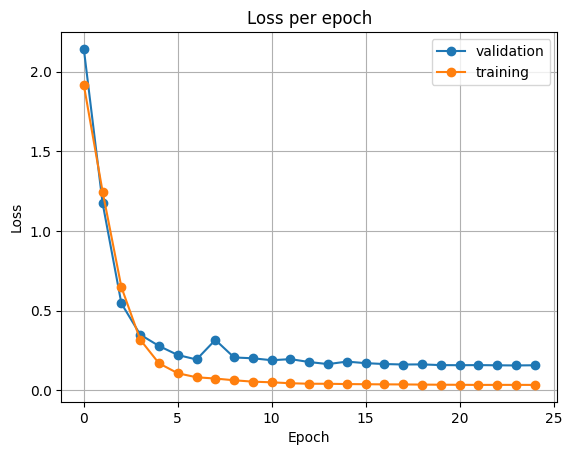

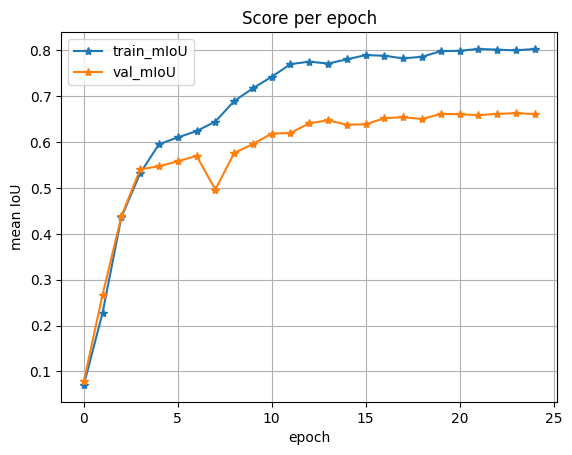

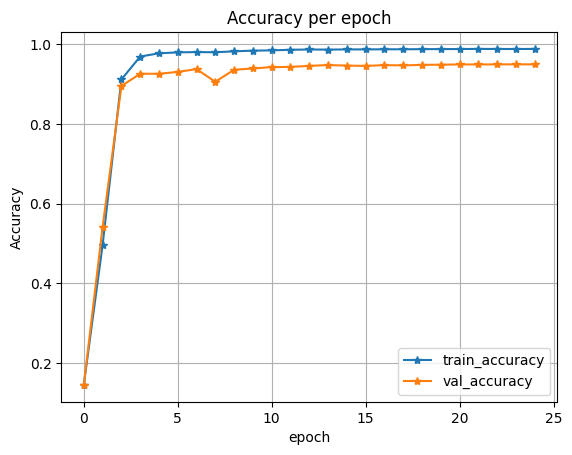

In [61]:
plot_loss(history_unet)
plot_score(history_unet)
plot_acc(history_unet)

### DeepLabV3Plus EfficientNet-B5 model

In [68]:
torch.cuda.empty_cache()
unet_model = unet_model.to('cpu')

Similar training pattern to Unet, but with slightly better performance.
Final metrics (approx.):

* Validation Loss: 0.18
* Validation mIoU: 0.65
* Validation Accuracy: 0.95

In [69]:
history_deeplabv3plus, deeplabv3plus_model = train_model(
    'DeepLabV3Plus', 
    'efficientnet-b3', 
    epochs, 
    learning_rate, 
    train_loader, 
    val_loader, 
    criterion, 
    device
)

Validating: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Loss decreasing inf >> 1.235
Loss did not decrease for 1 time
Epoch:1/25.. Train Loss: 1.141.. Val Loss: 1.235.. Train mIoU:0.256.. Val mIoU: 0.213.. Train Acc:0.603.. Val Acc:0.501.. Time: 0.24m


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Loss decreasing 1.235 >> 0.540
Loss did not decrease for 1 time
Epoch:2/25.. Train Loss: 0.590.. Val Loss: 0.540.. Train mIoU:0.390.. Val mIoU: 0.368.. Train Acc:0.893.. Val Acc:0.853.. Time: 0.24m


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Loss decreasing 0.540 >> 0.327
Loss did not decrease for 1 time
Epoch:3/25.. Train Loss: 0.266.. Val Loss: 0.327.. Train mIoU:0.476.. Val mIoU: 0.412.. Train Acc:0.946.. Val Acc:0.888.. Time: 0.24m


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Loss decreasing 0.327 >> 0.291
Loss did not decrease for 1 time
Epoch:4/25.. Train Loss: 0.132.. Val Loss: 0.291.. Train mIoU:0.553.. Val mIoU: 0.417.. Train Acc:0.969.. Val Acc:0.900.. Time: 0.24m


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Loss decreasing 0.291 >> 0.251
Saving best model
Epoch:5/25.. Train Loss: 0.086.. Val Loss: 0.251.. Train mIoU:0.663.. Val mIoU: 0.501.. Train Acc:0.976.. Val Acc:0.912.. Time: 0.24m


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Loss decreasing 0.251 >> 0.215
Loss did not decrease for 1 time
Epoch:6/25.. Train Loss: 0.069.. Val Loss: 0.215.. Train mIoU:0.700.. Val mIoU: 0.567.. Train Acc:0.978.. Val Acc:0.927.. Time: 0.24m


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Loss decreasing 0.215 >> 0.195
Loss did not decrease for 1 time
Epoch:7/25.. Train Loss: 0.057.. Val Loss: 0.195.. Train mIoU:0.724.. Val mIoU: 0.589.. Train Acc:0.981.. Val Acc:0.931.. Time: 0.24m


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Loss decreasing 0.195 >> 0.175
Loss did not decrease for 1 time
Epoch:8/25.. Train Loss: 0.053.. Val Loss: 0.175.. Train mIoU:0.739.. Val mIoU: 0.606.. Train Acc:0.982.. Val Acc:0.938.. Time: 0.24m


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Loss decreasing 0.175 >> 0.167
Loss did not decrease for 1 time
Epoch:9/25.. Train Loss: 0.049.. Val Loss: 0.167.. Train mIoU:0.746.. Val mIoU: 0.633.. Train Acc:0.983.. Val Acc:0.941.. Time: 0.24m


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Loss decreasing 0.167 >> 0.160
Saving best model
Epoch:10/25.. Train Loss: 0.047.. Val Loss: 0.160.. Train mIoU:0.756.. Val mIoU: 0.631.. Train Acc:0.983.. Val Acc:0.942.. Time: 0.24m


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Loss decreasing 0.160 >> 0.160
Loss did not decrease for 1 time
Epoch:11/25.. Train Loss: 0.044.. Val Loss: 0.160.. Train mIoU:0.762.. Val mIoU: 0.634.. Train Acc:0.984.. Val Acc:0.944.. Time: 0.24m


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch:12/25.. Train Loss: 0.043.. Val Loss: 0.160.. Train mIoU:0.761.. Val mIoU: 0.638.. Train Acc:0.984.. Val Acc:0.944.. Time: 0.24m


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch:13/25.. Train Loss: 0.040.. Val Loss: 0.191.. Train mIoU:0.782.. Val mIoU: 0.599.. Train Acc:0.985.. Val Acc:0.941.. Time: 0.24m


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch:14/25.. Train Loss: 0.039.. Val Loss: 0.174.. Train mIoU:0.775.. Val mIoU: 0.613.. Train Acc:0.985.. Val Acc:0.942.. Time: 0.24m


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Loss decreasing 0.160 >> 0.154
Saving best model
Epoch:15/25.. Train Loss: 0.039.. Val Loss: 0.154.. Train mIoU:0.780.. Val mIoU: 0.647.. Train Acc:0.985.. Val Acc:0.946.. Time: 0.24m


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch:16/25.. Train Loss: 0.037.. Val Loss: 0.155.. Train mIoU:0.782.. Val mIoU: 0.645.. Train Acc:0.986.. Val Acc:0.947.. Time: 0.24m


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch:17/25.. Train Loss: 0.037.. Val Loss: 0.167.. Train mIoU:0.783.. Val mIoU: 0.631.. Train Acc:0.986.. Val Acc:0.944.. Time: 0.24m


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch:18/25.. Train Loss: 0.037.. Val Loss: 0.166.. Train mIoU:0.796.. Val mIoU: 0.622.. Train Acc:0.986.. Val Acc:0.943.. Time: 0.24m


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Loss decreasing 0.154 >> 0.148
Loss did not decrease for 1 time
Epoch:19/25.. Train Loss: 0.035.. Val Loss: 0.148.. Train mIoU:0.795.. Val mIoU: 0.649.. Train Acc:0.986.. Val Acc:0.946.. Time: 0.24m


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch:20/25.. Train Loss: 0.035.. Val Loss: 0.156.. Train mIoU:0.800.. Val mIoU: 0.638.. Train Acc:0.987.. Val Acc:0.946.. Time: 0.24m


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch:21/25.. Train Loss: 0.035.. Val Loss: 0.158.. Train mIoU:0.799.. Val mIoU: 0.636.. Train Acc:0.987.. Val Acc:0.946.. Time: 0.24m


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch:22/25.. Train Loss: 0.034.. Val Loss: 0.155.. Train mIoU:0.797.. Val mIoU: 0.640.. Train Acc:0.987.. Val Acc:0.946.. Time: 0.24m


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch:23/25.. Train Loss: 0.034.. Val Loss: 0.154.. Train mIoU:0.803.. Val mIoU: 0.642.. Train Acc:0.987.. Val Acc:0.946.. Time: 0.24m


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch:24/25.. Train Loss: 0.034.. Val Loss: 0.155.. Train mIoU:0.807.. Val mIoU: 0.641.. Train Acc:0.987.. Val Acc:0.946.. Time: 0.24m


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

Epoch:25/25.. Train Loss: 0.034.. Val Loss: 0.156.. Train mIoU:0.804.. Val mIoU: 0.638.. Train Acc:0.987.. Val Acc:0.946.. Time: 0.24m
Total time: 6.04 m


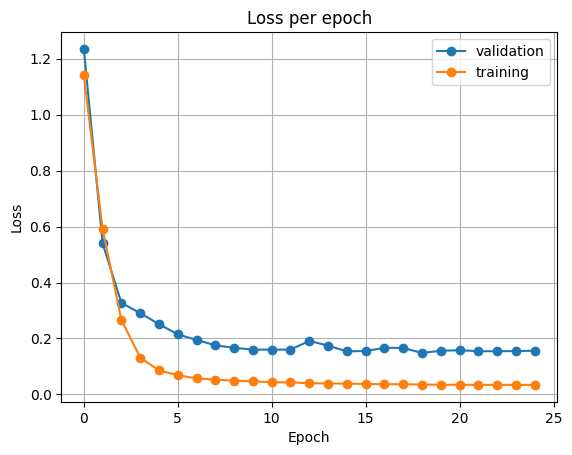

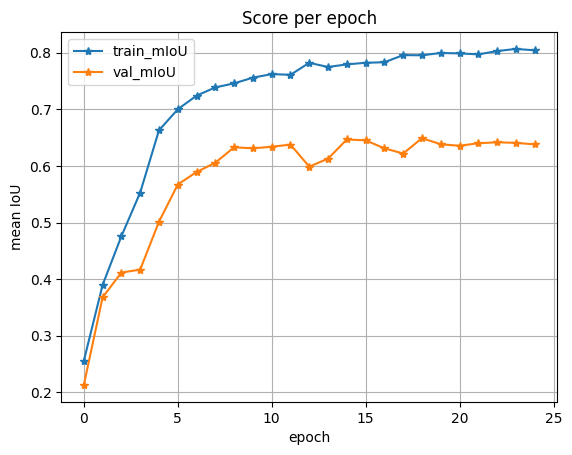

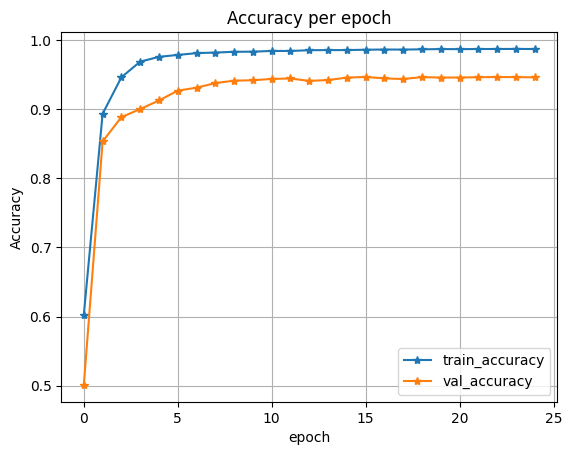

In [70]:
plot_loss(history_deeplabv3plus)
plot_score(history_deeplabv3plus)
plot_acc(history_deeplabv3plus)

## Performance Comparison

- Both models show good performance, with high accuracy and reasonable mIoU scores.
- DeepLabV3Plus seems to have slightly lower validation loss, but Unet has a marginally higher mIoU.
- Both models show signs of convergence, with performance stabilizing in later epochs.

## Observations

- Both models show good generalization, with validation metrics closely following training metrics.
- There's a slight gap between training and validation performance, indicating some overfitting, but it's not severe.
- The high accuracy suggests the models are effective at pixel-level classification, but the lower mIoU scores indicate room for improvement in precise boundary delineation.

## Evaluation

A `predict_image_mask_miou` function is defined for evaluating the model on individual images. It calculates the mIoU score and generates the segmentation mask for a given input image.

In [82]:
def predict_image_mask_miou(model, image, mask, device: torch.device, mean=[0.485], std=[0.229]):
    model.eval()
    model.to(device)
    image = image.to(device)
    mask = mask.to(device)
    
    print(f"Image shape: {image.shape}")
    print(f"Mask shape: {mask.shape}")
    
    with torch.no_grad():
        output = model(image)
        mask = mask.permute(0, 3, 1, 2)
        
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        
        masked = masked.cpu()
        output = output.cpu()
        
    return masked, score, output

### Unet Model

In [83]:
image, mask = next(iter(val_loader))
pred_mask, score, output = predict_image_mask_miou(unet_model, image, mask, device)
semantic_map = mask_to_onehot(torch.unsqueeze(mask, -1).numpy(),palette)

Image shape: torch.Size([24, 1, 256, 256])
Mask shape: torch.Size([24, 256, 256, 4])


A visualize_predictions function is defined to display original images, true masks, predicted masks, and individual class predictions. The visualization includes:

* Original image
* True mask (all classes combined)
* Predicted mask (all classes combined)
* Individual class visualizations (for the first 3 classes)

In [92]:
def visualize_predictions(image_batch, mask_batch, pred_batch, num_samples=5):
    plt.figure(figsize=(20, 4 * num_samples))
    num_samples = min(num_samples, image_batch.shape[0])
    
    for i in range(num_samples):
        # Original Image
        ax = plt.subplot(num_samples, 6, i * 6 + 1)
        plt.imshow(image_batch[i].squeeze().cpu().numpy(), cmap='gray')
        plt.title('Original Image')
        ax.axis('off')

        # True Mask (all classes combined)
        ax = plt.subplot(num_samples, 6, i * 6 + 2)
        true_mask_combined = np.argmax(mask_batch[i].cpu().numpy(), axis=-1)
        plt.imshow(true_mask_combined, cmap='nipy_spectral')
        plt.title('True Mask (All Classes)')
        ax.axis('off')

        # Predicted Mask (all classes combined)
        ax = plt.subplot(num_samples, 6, i * 6 + 3)
        pred_mask_combined = torch.argmax(pred_batch[i], dim=0).cpu().numpy()
        plt.imshow(pred_mask_combined, cmap='nipy_spectral')
        plt.title('Predicted Mask (All Classes)')
        ax.axis('off')

        # Individual class visualizations
        for j in range(3):  # Visualize first 3 classes
            ax = plt.subplot(num_samples, 6, i * 6 + j + 4)
            
            mask_to_show = np.zeros((*mask_batch.shape[1:3], 3))
            mask_to_show[..., 1] = mask_batch[i, :, :, j].cpu().numpy()
            mask_to_show[..., 0] = pred_batch[i, j].cpu().numpy() > 0.5

            plt.imshow(mask_to_show)
            plt.title(f'Class {j} (Green: True, Red: Pred)')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

In [90]:
image = image.cpu()
mask = mask.cpu()
output = output.cpu()

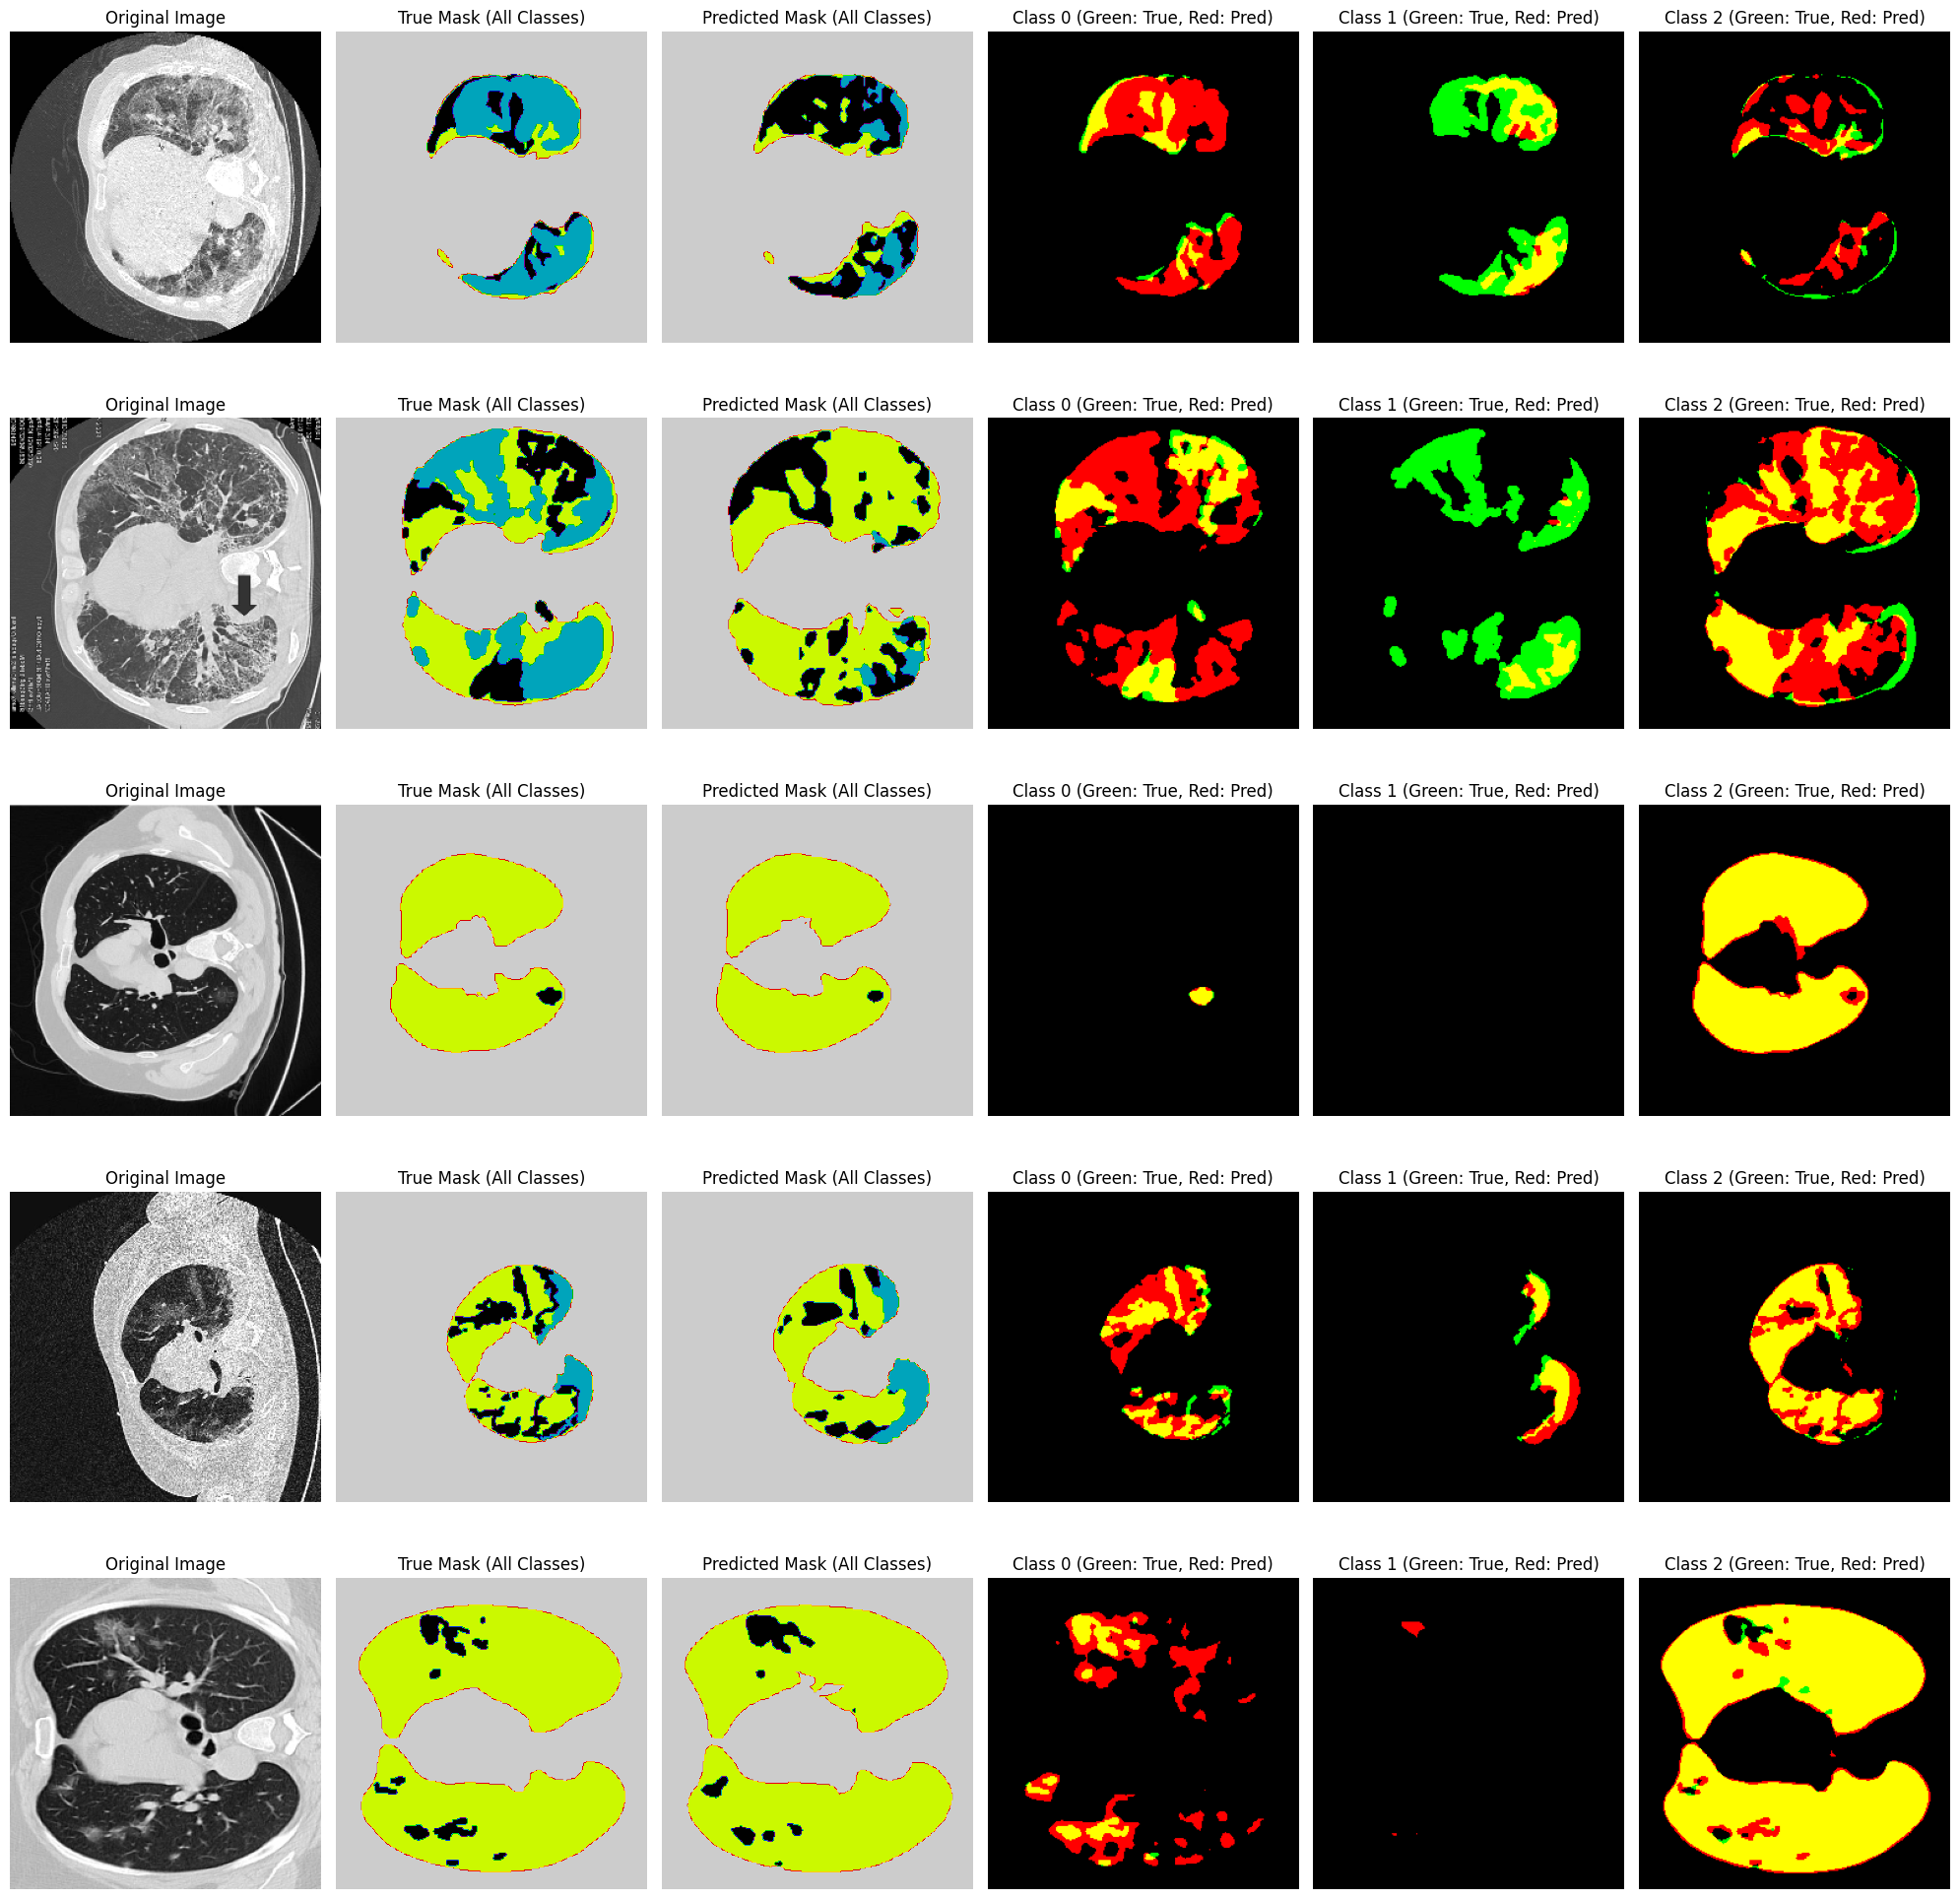

In [93]:
visualize_predictions(image, mask, output)

### DeepLabV3Plus

In [94]:
image, mask = next(iter(val_loader))
pred_mask, score, output = predict_image_mask_miou(deeplabv3plus_model, image, mask, device=device)
semantic_map = mask_to_onehot(torch.unsqueeze(mask,-1).numpy(),palette)

Image shape: torch.Size([24, 1, 256, 256])
Mask shape: torch.Size([24, 256, 256, 4])


In [95]:
image = image.cpu()
mask = mask.cpu()
output = output.cpu()

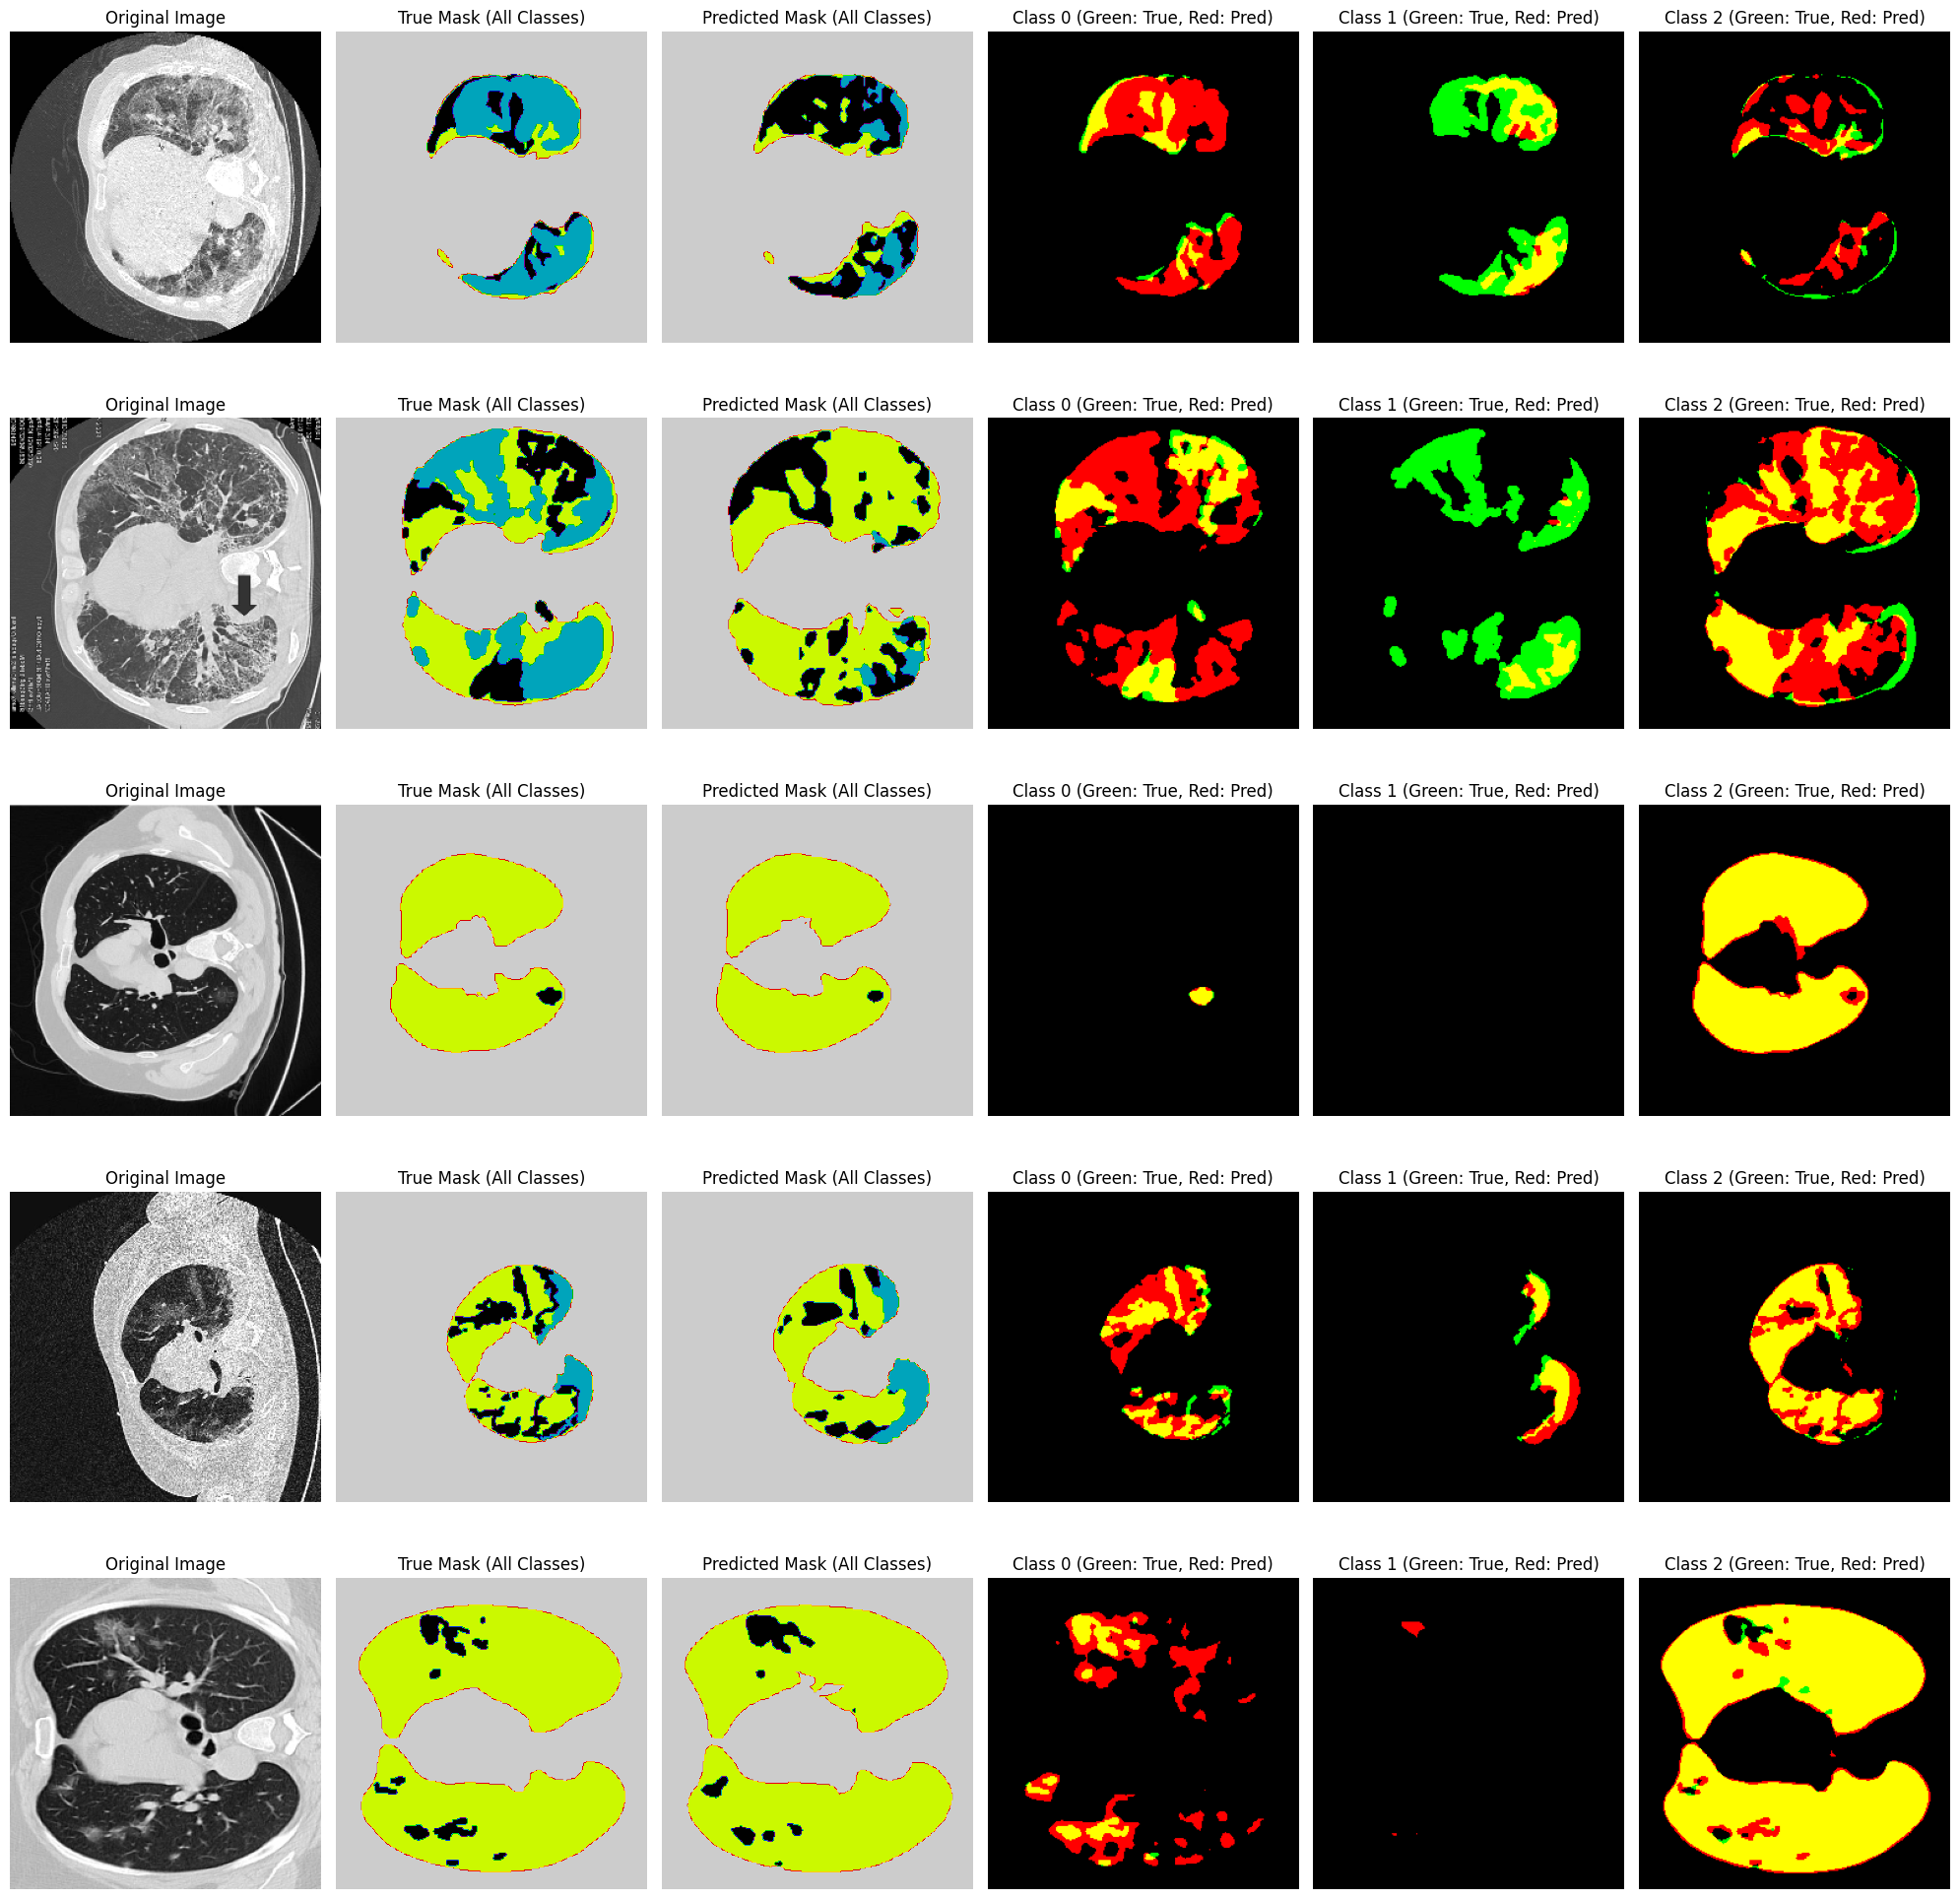

In [96]:
visualize(image, mask, output)

The visualizations show that both models (Unet and DeepLabV3Plus) perform reasonably well in segmenting the lung CT scans. The predicted masks closely resemble the true masks, with some variations in boundary precision and small feature detection.

## MIOU Score

A miou_score function is defined to calculate the mean Intersection over Union (MIOU) score for the test set. MIOU scores are calculated for both Unet and DeepLabV3Plus models:
* Unet MIOU: approximately 0.66
* DeepLabV3Plus MIOU: approximately 0.63

In [97]:
def miou_score(model, test_set, device):
    score_iou = []
    
    for i, data in enumerate(tqdm(test_set)):
        img, mask = data
        pred_mask, score, output = predict_image_mask_miou(model, img, mask, device)
        
        score_iou.append(score)
        
    return score_iou

### Unet

In [102]:
mob_miou = miou_score(unet_model, val_loader, device)
print(mob_miou)

100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

Image shape: torch.Size([24, 1, 256, 256])
Mask shape: torch.Size([24, 256, 256, 4])
[0.6610711693365462]


### DeepLabV3Plus

In [101]:
mob_miou = miou_score(deeplabv3plus_model, val_loader, device)
print(mob_miou)

100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

Image shape: torch.Size([24, 1, 256, 256])
Mask shape: torch.Size([24, 256, 256, 4])
[0.6381128323768605]


## Test Predictions

A `test_predict` function is defined to make predictions on new images. The function normalizes the input image, runs it through the model, and applies a softmax function to get class probabilities.

In [115]:
def test_predict(model, image, device:torch.device, mean=[0.485], std=[0.229]):
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    
    model.to(device)
    image = image.to(device)
    
    with torch.no_grad():
        output = model(torch.unsqueeze(image, 1))
        output = nn.Softmax(dim=1)(output)
        
    return output.squeeze(0).permute(1, 2, 0).cpu().numpy()

The code sets up batch prediction for a set of test images. It uses the test_predict function to generate predictions for each image in the batch.

In [116]:
image_batch = np.stack([val_transformations(image=img)['image'] for img in test_images_medseg], axis=0)

print(torch.from_numpy(image_batch).shape)
print(image_batch[i].shape)

torch.Size([10, 256, 256, 1])
(256, 256, 1)


### Unet

In [117]:
output = np.zeros((10,256,256,4))

for i in range(10):   
    output[i] = test_predict(unet_model, image_batch[i], device)
    
print(output.shape)

(10, 256, 256, 4)


A visualize_test_predictions function is defined to display the test images and their corresponding predicted segmentation masks.

In [125]:
def visualize_test_predictions(image_batch, pred_batch, num_samples=5):
    plt.figure(figsize=(15, 4 * num_samples))
    num_samples = min(num_samples, image_batch.shape[0])
    
    for i in range(num_samples):
        # Original Image
        ax = plt.subplot(num_samples, 5, i * 5 + 1)
        plt.imshow(image_batch[i], cmap='gray')
        plt.title('Original Image')
        ax.axis('off')

        # Predicted Mask (all classes combined)
        ax = plt.subplot(num_samples, 5, i * 5 + 2)
        pred_mask_combined = np.argmax(pred_batch[i], axis=-1)
        plt.imshow(pred_mask_combined, cmap='nipy_spectral')
        plt.title('Predicted Mask (All Classes)')
        ax.axis('off')

        # Individual class visualizations
        for j in range(3):  # Visualize first 3 classes
            ax = plt.subplot(num_samples, 5, i * 5 + j + 3)
            
            plt.imshow(pred_batch[i, :, :, j], cmap='gray')
            plt.title(f'Class {j} Prediction')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

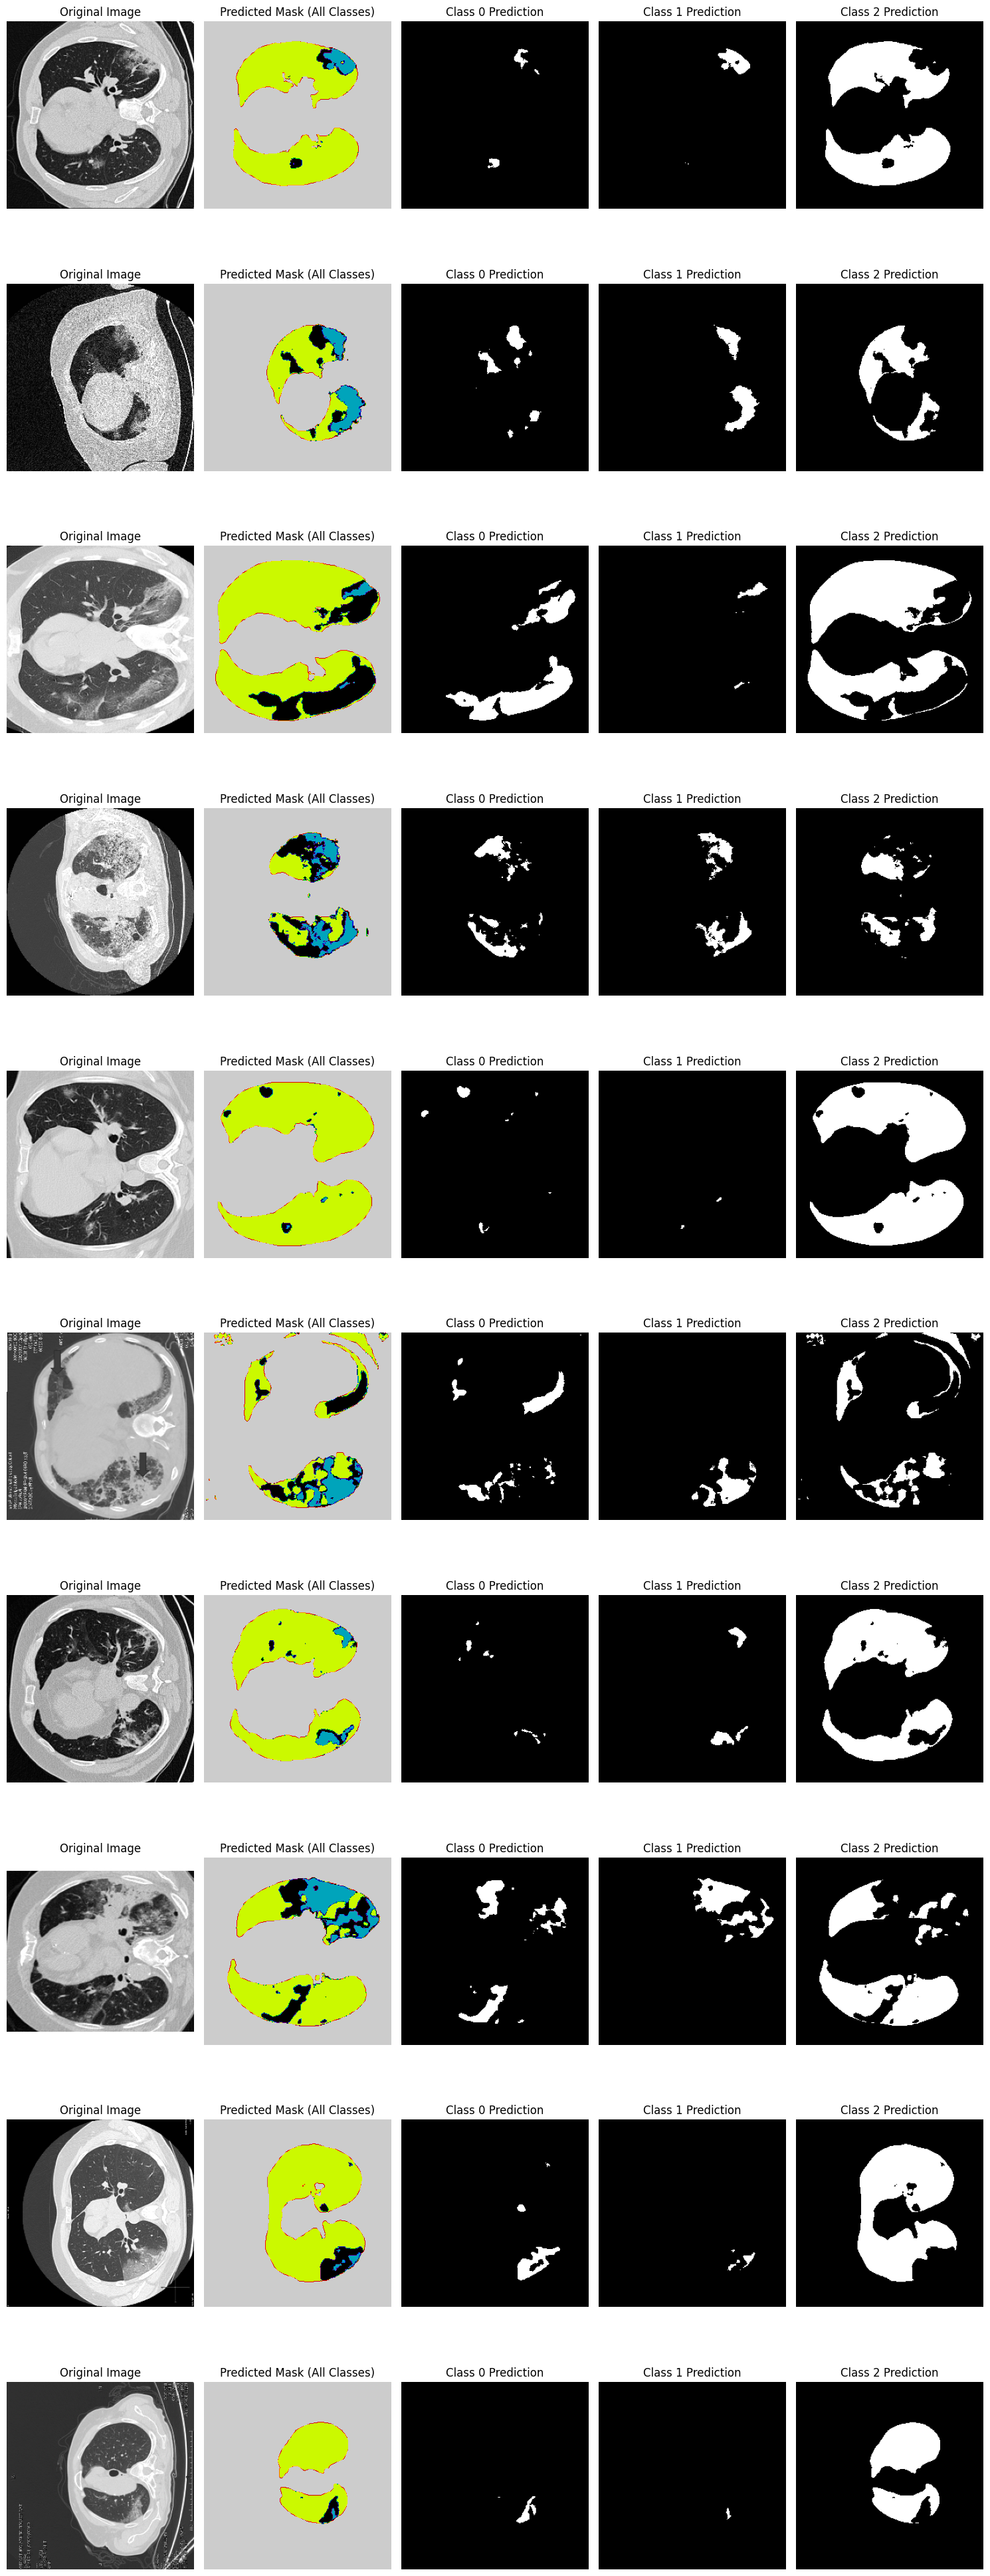

In [126]:
test_masks_prediction = output > 0.5
visualize_test_predictions(image_batch, test_masks_prediction, num_samples=len(test_images_medseg))

### DeepLabV3Plus

In [128]:
output = np.zeros((10,256,256,4))
for i in range(10):   
    output[i] = test_predict(deeplabv3plus_model, image_batch[i], device)
    
print(output.shape)

(10, 256, 256, 4)


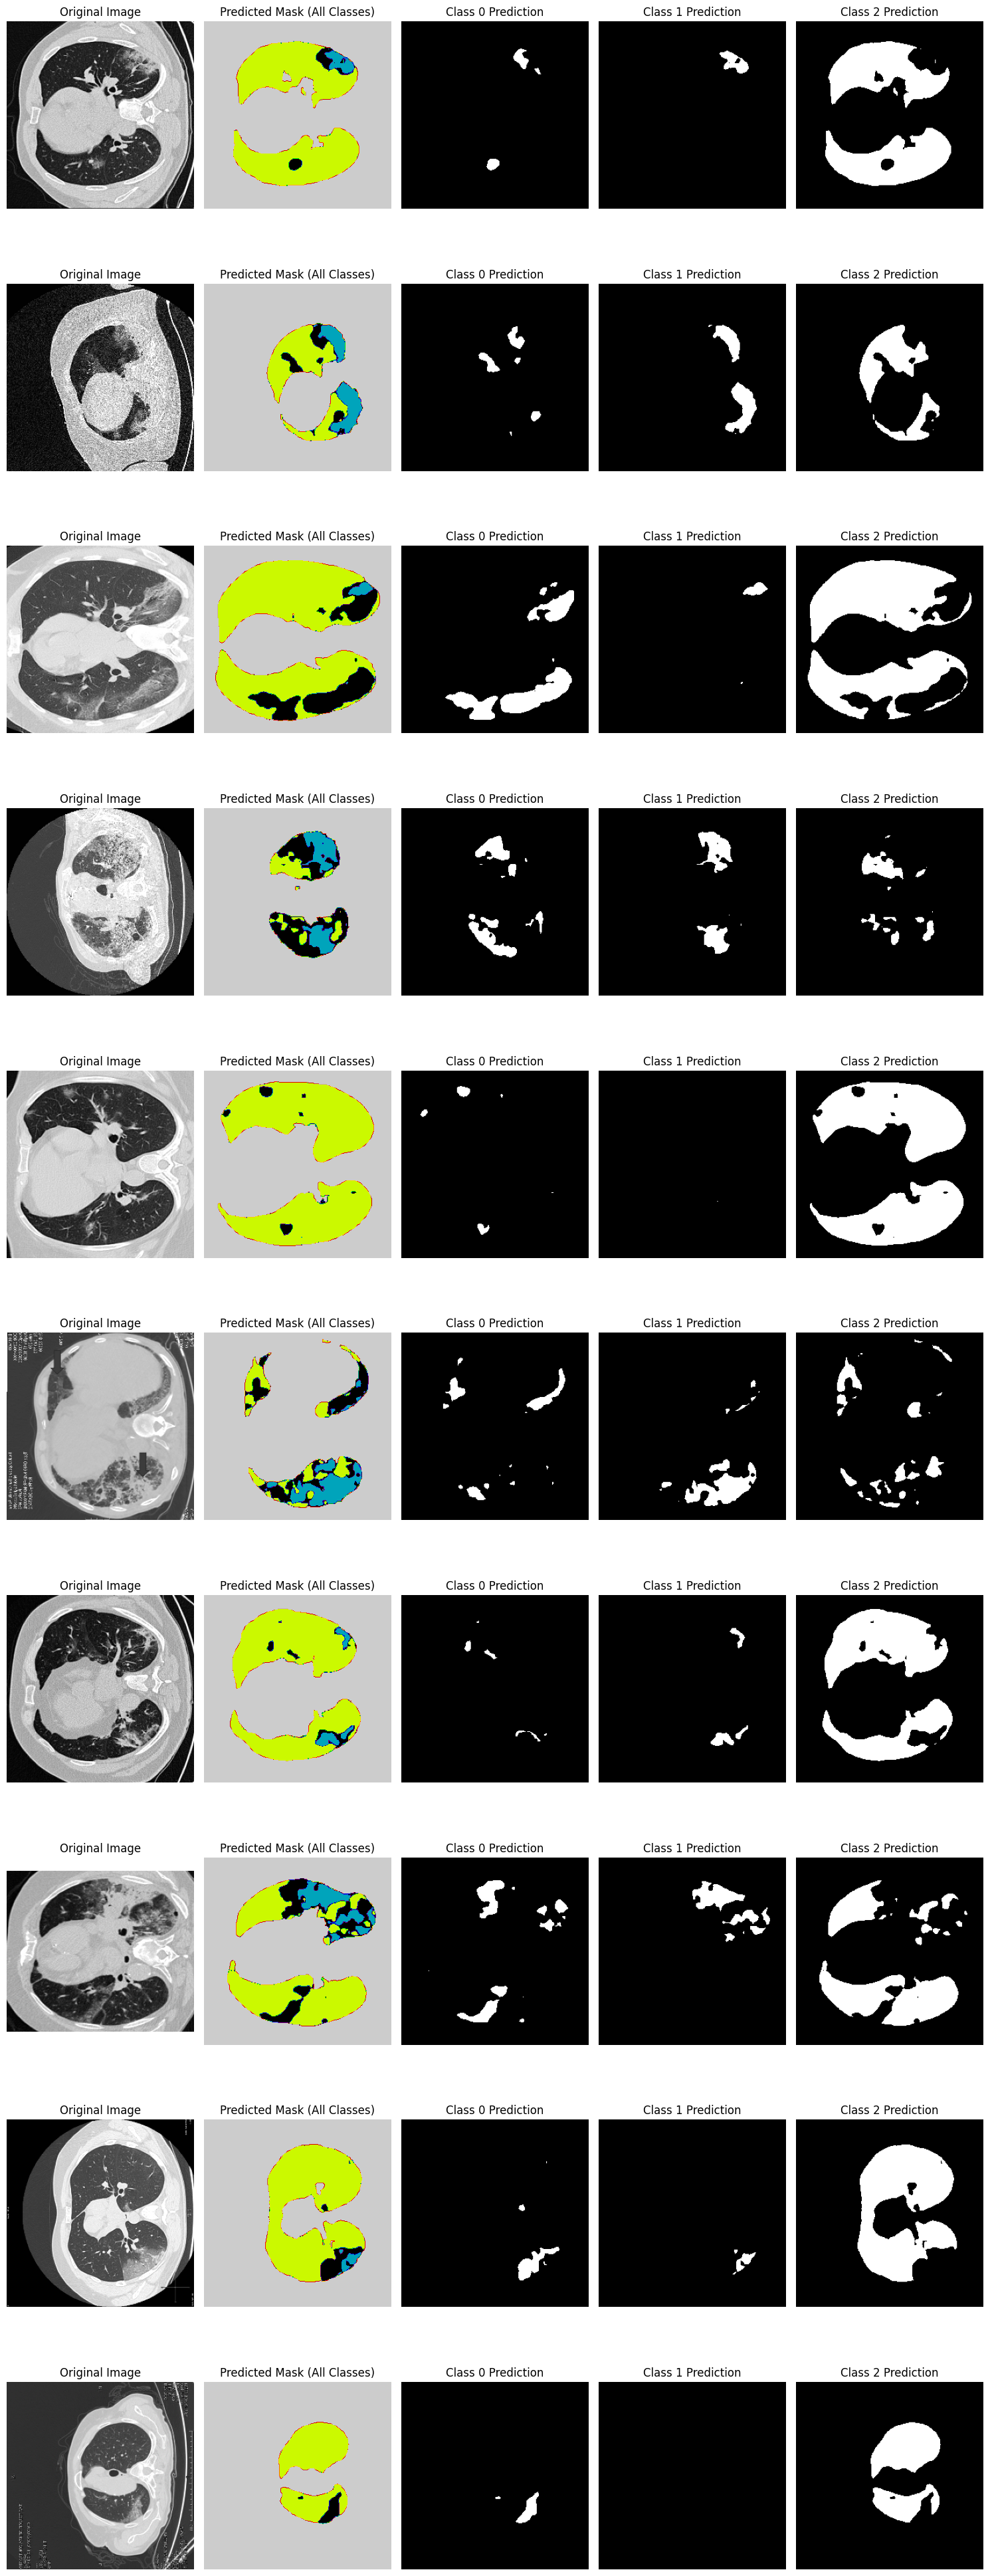

In [129]:
test_masks_prediction = output > 0.5
visualize_test_predictions(image_batch, test_masks_prediction, num_samples=len(test_images_medseg))

## Key Observations

* Both models (Unet and DeepLabV3Plus) show good performance in segmenting lung CT scans.
* The Unet model slightly outperforms the DeepLabV3Plus model in terms of MIOU score on the validation set.
* The visualizations demonstrate that the models can effectively identify different regions in the lung CT scans, which could be crucial for COVID-19 or other lung disease diagnosis.
* The code provides a comprehensive pipeline for model evaluation, from individual image prediction to batch processing and visualization of results.

## Model Submission

In [130]:
import scipy
import pandas as pd

In [131]:
test_masks_prediction_original_size = scipy.ndimage.zoom(test_masks_prediction[..., :-2], (1, 2, 2, 1), order=0)
test_masks_prediction_original_size.shape

(10, 512, 512, 2)

In [132]:
pd.DataFrame(
             data=np.stack((np.arange(len(test_masks_prediction_original_size.ravel())), 
                            test_masks_prediction_original_size.ravel().astype(int)),
                            axis=-1), 
             columns=['Id', 'Predicted'])\
.set_index('Id').to_csv('sub.csv')